# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

None


Using TensorFlow backend.


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Global variables

In [20]:
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits =  10 # 7 # 5 # 10 # 7 
test_size = 0.1

embedding_dimension = 200 # 300
batch_size = 16 # 64
nb_epochs = 100
dropout = 0.5
recurrent_dropout=  0.5 #0.3
patience = 10
verbose = 1

useF1Score = True # True

## Create <caption,label> CSV files

In [17]:
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

## Divide data into train/val/test datasets

In [18]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))



input_x, test_x, input_y,  test_y = train_test_split(df["caption"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()


inputDataset.to_csv(inputDataset_csv_path, index=False, sep="|")
testDataset.to_csv(testDataset_csv_path, index=False, sep="|")

print("df.head()\n", df.head())
print("\n")
print("df.tail()\n", df.tail())
print("\n")
print("inputDataset.head()\n", inputDataset.head())
print("testDataset.head()\n", testDataset.head())
print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())

df.head()
   imageId                                            caption  label
0      I1           two acorns lying ground next oak leaves.      0
1     I10  bar several bottles wine partially-filled wine...      0
2    I100  ruined walls church backdrop white clouds blue...      0
3    I101  man free fall attached blue bungee jumping app...      0
4    I102  falling man attached bungee jumping apparatus....      0


df.tail()
     imageId                                            caption  label
895     I95             square section stones laid brick wall.      0
896     I96  arched bridge park tall trees background, ston...      1
897     I97  glass ball reflection fence woman taking picture.      0
898     I98                   large soap bubbles floating air.      1
899     I99  three stained-glass windows depicting scenes l...      1


inputDataset.head()
    index                                            caption  label
0    716          two sewer grates middle paved brick road

## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [6]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 1193514
embedding dimension : (200,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


config:
 {'kfold_splits': 10, 'batch_size': 16, 'embedding_dimension': 200, 'recurrent_dropout': 0.5, 'dropout': 0.5, 'nb_epochs': 100, 'useF1Score': True, 'verbose': 1, 'seed': 7}
# words:  1193514  word vector dimension 200
Label distribution:  label
-1    147
 0    378
 1    285
Name: label, dtype: int64
max_seq_len 38
train_indices[:5] [0 1 3 4 5] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 2 25 62 66 73] val_indices[-5:] [750 755 781 790 792]

class_weights [0.71 0.96 1.81]
class_to_index {0: 0, 1: 1, -1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    134
 0    340
 1    254
Name: label, dtype: int64
Val label distribution:  label
-1    13
 0    38
 1    31
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 8s 11ms/step - loss: 1.0553 - acc: 0.4107 - f1: 0.0376 - recall: 0.0220 - precision: 0.1795 - val_loss: 0.9975 - val_acc: 0.4634 - val_f1: 0.0000e+00 - val_recal

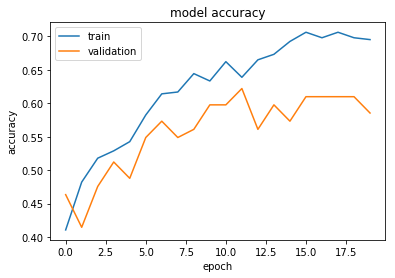

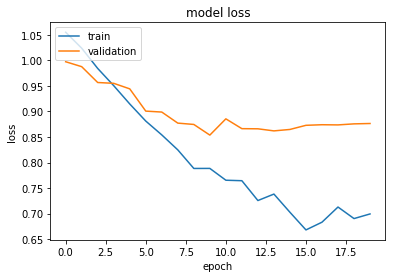

Time passed for training 148.6213972568512
train_indices[:5] [0 2 3 4 5] train_indices[-5:] [803 806 807 808 809]
val_indices[:5] [ 1 10 12 13 29] val_indices[-5:] [767 776 799 804 805]

class_weights [0.72 1.91 0.92]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    127
 0    338
 1    263
Name: label, dtype: int64
Val label distribution:  label
-1    20
 0    40
 1    22
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 8s 11ms/step - loss: 1.0728 - acc: 0.3805 - f1: 0.0381 - recall: 0.0206 - precision: 0.2894 - val_loss: 1.0743 - val_acc: 0.4878 - val_f1: 0.0230 - val_recall: 0.0122 - val_precision: 0.1951
Epoch 2/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0147 - acc: 0.4643 - f1: 0.2085 - recall: 0.1305 - precision: 0.6256 - val_loss: 1.0487 - val_acc: 0.4878 - val_f1: 0.1358 - val_recall: 0.0854 - val_precision: 0.3382
Epoch 

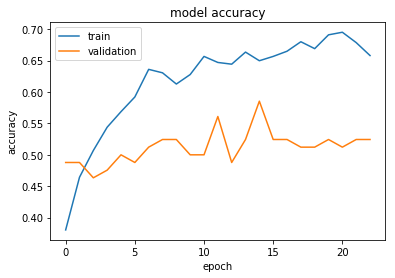

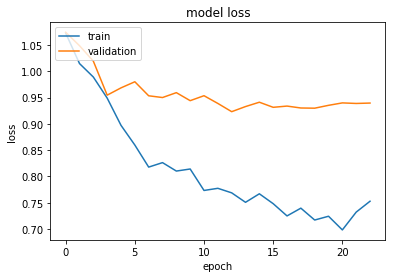

Time passed for training 166.42957878112793
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 5  7 17 20 32] val_indices[-5:] [715 727 741 772 788]

class_weights [0.7  1.91 0.95]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    127
 0    346
 1    255
Name: label, dtype: int64
Val label distribution:  label
-1    20
 0    32
 1    30
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 8s 11ms/step - loss: 1.0708 - acc: 0.4052 - f1: 0.0125 - recall: 0.0069 - precision: 0.0769 - val_loss: 1.0680 - val_acc: 0.3902 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0199 - acc: 0.4643 - f1: 0.1131 - recall: 0.0714 - precision: 0.3869 - val_loss: 1.0669 - val_acc: 0.3902 - val_f1: 0.2918 - val_recall: 0.2317 - val_precision: 


Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 31/100
728/728 [==============================] - 6s 8ms/step - loss: 0.6473 - acc: 0.7349 - f1: 0.7146 - recall: 0.6813 - precision: 0.7536 - val_loss: 0.8164 - val_acc: 0.6463 - val_f1: 0.6181 - val_recall: 0.5976 - val_precision: 0.6420
Epoch 32/100
728/728 [==============================] - 6s 8ms/step - loss: 0.6958 - acc: 0.6841 - f1: 0.6796 - recall: 0.6401 - precision: 0.7277 - val_loss: 0.8167 - val_acc: 0.6463 - val_f1: 0.6075 - val_recall: 0.5854 - val_precision: 0.6345

Epoch 00032: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
best_val_acc:  0.6463414634146342
best_f1:  0.6223897643205596
best_train_acc 0.7348901098901099
best_val_acc 0.6463414634146342
best_f1 0.6223897643205596
best_train_f1 0.7146008329077082


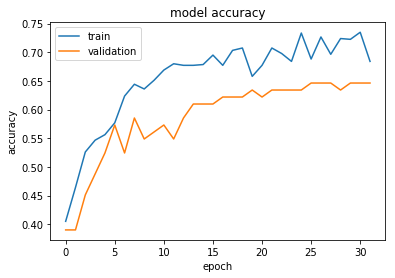

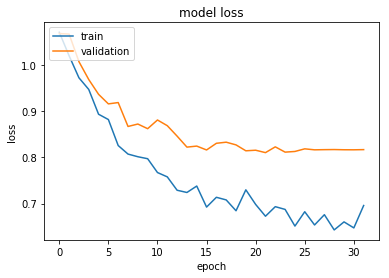

Time passed for training 219.17698764801025
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [11 16 26 27 30] val_indices[-5:] [723 729 744 749 779]

class_weights [0.72 1.8  0.94]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    135
 0    335
 1    258
Name: label, dtype: int64
Val label distribution:  label
-1    12
 0    43
 1    27
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 8s 11ms/step - loss: 1.0703 - acc: 0.4245 - f1: 0.0339 - recall: 0.0206 - precision: 0.1112 - val_loss: 0.9981 - val_acc: 0.5244 - val_f1: 0.2474 - val_recall: 0.1829 - val_precision: 0.3906
Epoch 2/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0352 - acc: 0.4602 - f1: 0.1647 - recall: 0.1071 - precision: 0.4066 - val_loss: 0.9783 - val_acc: 0.5732 - val_f1: 0.1010 - val_recall: 0.0610 - val_precision: 0.3902
Epoch


Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 31/100
728/728 [==============================] - 6s 8ms/step - loss: 0.6934 - acc: 0.6841 - f1: 0.6688 - recall: 0.6195 - precision: 0.7331 - val_loss: 0.7344 - val_acc: 0.7073 - val_f1: 0.6139 - val_recall: 0.5610 - val_precision: 0.6835
Epoch 32/100
728/728 [==============================] - 6s 8ms/step - loss: 0.6999 - acc: 0.7198 - f1: 0.6869 - recall: 0.6429 - precision: 0.7407 - val_loss: 0.7337 - val_acc: 0.7073 - val_f1: 0.6068 - val_recall: 0.5488 - val_precision: 0.6826
Epoch 33/100
728/728 [==============================] - 6s 8ms/step - loss: 0.7229 - acc: 0.6676 - f1: 0.6473 - recall: 0.6044 - precision: 0.7006 - val_loss: 0.7329 - val_acc: 0.7073 - val_f1: 0.6068 - val_recall: 0.5488 - val_precision: 0.6826
Epoch 34/100
728/728 [==============================] - 6s 8ms/step - loss: 0.6833 - acc: 0.6992 - f1: 0.6836 - recall: 0.6374 - precision: 0.7417 - val_loss: 0.7325 - val_acc: 0.70

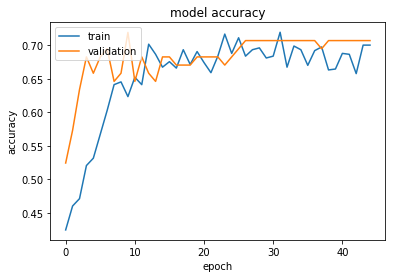

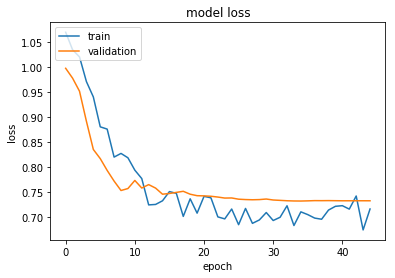

Time passed for training 293.28154969215393
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [803 804 805 807 808]
val_indices[:5] [ 6 15 19 22 24] val_indices[-5:] [784 786 796 806 809]

class_weights [0.71 1.84 0.96]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    132
 0    343
 1    253
Name: label, dtype: int64
Val label distribution:  label
-1    15
 0    35
 1    32
Name: label, dtype: int64
Train on 728 samples, validate on 82 samples
Epoch 1/100
728/728 [==============================] - 8s 11ms/step - loss: 1.0700 - acc: 0.4492 - f1: 0.0683 - recall: 0.0426 - precision: 0.2330 - val_loss: 1.0552 - val_acc: 0.4268 - val_f1: 0.3573 - val_recall: 0.3171 - val_precision: 0.4149
Epoch 2/100
728/728 [==============================] - 6s 8ms/step - loss: 1.0280 - acc: 0.4835 - f1: 0.1591 - recall: 0.1030 - precision: 0.4289 - val_loss: 1.0144 - val_acc: 0.4268 - val_f1: 0.2297 - val_recall: 0.1463 - val_precision: 0.6585
Epoch

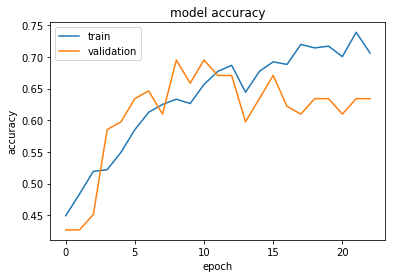

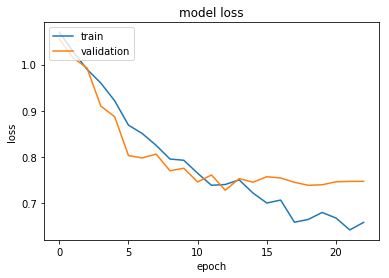

Time passed for training 168.66751170158386
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [804 805 806 808 809]
val_indices[:5] [21 38 40 46 76] val_indices[-5:] [745 759 793 797 807]

class_weights [0.71 1.96 0.93]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 729 	 VAL size: 81
Train label distribution:  label
-1    124
 0    344
 1    261
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    34
 1    24
Name: label, dtype: int64
Train on 729 samples, validate on 81 samples
Epoch 1/100
729/729 [==============================] - 8s 12ms/step - loss: 1.0486 - acc: 0.4499 - f1: 0.0983 - recall: 0.0617 - precision: 0.3303 - val_loss: 1.1077 - val_acc: 0.4321 - val_f1: 0.1415 - val_recall: 0.0864 - val_precision: 0.4115
Epoch 2/100
729/729 [==============================] - 6s 8ms/step - loss: 1.0219 - acc: 0.4883 - f1: 0.1910 - recall: 0.1248 - precision: 0.4709 - val_loss: 1.0790 - val_acc: 0.4938 - val_f1: 0.0648 - val_recall: 0.0370 - val_precision: 0.3292
Epoch

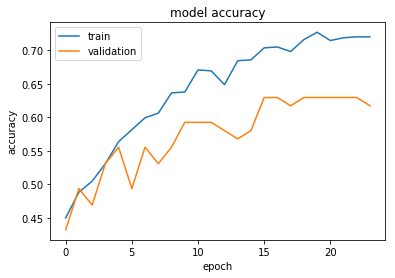

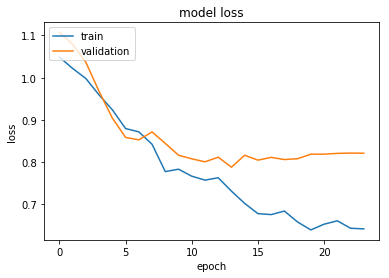

Time passed for training 176.94353985786438
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [44 59 63 69 71] val_indices[-5:] [769 782 794 798 801]

class_weights [0.71 1.79 0.98]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 729 	 VAL size: 81
Train label distribution:  label
-1    136
 0    344
 1    249
Name: label, dtype: int64
Val label distribution:  label
-1    11
 0    34
 1    36
Name: label, dtype: int64
Train on 729 samples, validate on 81 samples
Epoch 1/100
729/729 [==============================] - 8s 11ms/step - loss: 1.0523 - acc: 0.4348 - f1: 0.0473 - recall: 0.0274 - precision: 0.2044 - val_loss: 0.9735 - val_acc: 0.4321 - val_f1: 0.2132 - val_recall: 0.1358 - val_precision: 0.5267
Epoch 2/100
729/729 [==============================] - 5s 7ms/step - loss: 1.0314 - acc: 0.5089 - f1: 0.1996 - recall: 0.1331 - precision: 0.4626 - val_loss: 0.9410 - val_acc: 0.6049 - val_f1: 0.0232 - val_recall: 0.0123 - val_precision: 0.1975
Epoch


Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
best_val_acc:  0.7901234567901234
best_f1:  0.7366595798068576
best_train_acc 0.732510288229368
best_val_acc 0.7901234567901234
best_f1 0.7366595798068576
best_train_f1 0.72343173733464


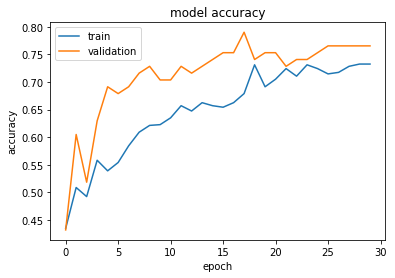

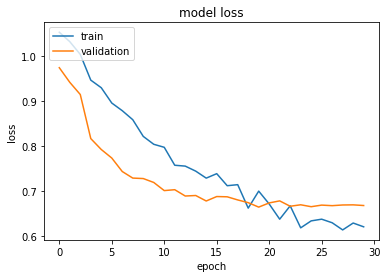

Time passed for training 199.68057465553284
train_indices[:5] [1 2 3 5 6] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 0  4 14 18 33] val_indices[-5:] [770 771 783 785 803]

class_weights [0.73 1.8  0.93]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 730 	 VAL size: 80
Train label distribution:  label
-1    135
 0    334
 1    261
Name: label, dtype: int64
Val label distribution:  label
-1    12
 0    44
 1    24
Name: label, dtype: int64
Train on 730 samples, validate on 80 samples
Epoch 1/100
730/730 [==============================] - 7s 10ms/step - loss: 1.0569 - acc: 0.4219 - f1: 0.0581 - recall: 0.0342 - precision: 0.2274 - val_loss: 0.9945 - val_acc: 0.5500 - val_f1: 0.2412 - val_recall: 0.1625 - val_precision: 0.4829
Epoch 2/100
730/730 [==============================] - 5s 7ms/step - loss: 1.0259 - acc: 0.4658 - f1: 0.1357 - recall: 0.0836 - precision: 0.4506 - val_loss: 0.9738 - val_acc: 0.5625 - val_f1: 0.0858 - val_recall: 0.0500 - val_precision: 0.4000
Epoch

Epoch 30/100
730/730 [==============================] - 5s 7ms/step - loss: 0.7207 - acc: 0.6890 - f1: 0.6606 - recall: 0.6178 - precision: 0.7163 - val_loss: 0.7636 - val_acc: 0.6750 - val_f1: 0.6687 - val_recall: 0.6500 - val_precision: 0.6902

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
best_val_acc:  0.6875
best_f1:  0.6721773743629456
best_train_acc 0.7150684933139854
best_val_acc 0.6875
best_f1 0.6721773743629456
best_train_f1 0.6891828767240864


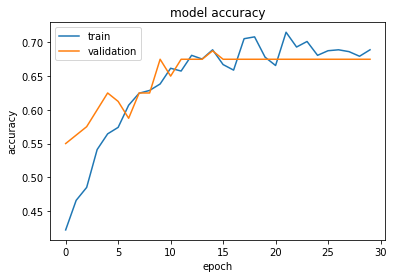

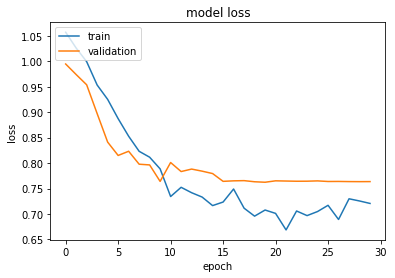

Time passed for training 196.04728388786316
train_indices[:5] [0 1 2 4 5] train_indices[-5:] [804 805 806 807 809]
val_indices[:5] [ 3  9 23 31 35] val_indices[-5:] [787 789 791 795 808]

class_weights [0.73 1.75 0.95]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 731 	 VAL size: 79
Train label distribution:  label
-1    139
 0    336
 1    256
Name: label, dtype: int64
Val label distribution:  label
-1     8
 0    42
 1    29
Name: label, dtype: int64
Train on 731 samples, validate on 79 samples
Epoch 1/100
731/731 [==============================] - 8s 10ms/step - loss: 1.0545 - acc: 0.4227 - f1: 0.0194 - recall: 0.0109 - precision: 0.1060 - val_loss: 0.9353 - val_acc: 0.5316 - val_f1: 0.3259 - val_recall: 0.2405 - val_precision: 0.5080
Epoch 2/100
731/731 [==============================] - 5s 7ms/step - loss: 1.0303 - acc: 0.4528 - f1: 0.1652 - recall: 0.1040 - precision: 0.4947 - val_loss: 0.9221 - val_acc: 0.5443 - val_f1: 0.2559 - val_recall: 0.1646 - val_precision: 0.6148
Epoch

731/731 [==============================] - 5s 7ms/step - loss: 0.6646 - acc: 0.7196 - f1: 0.6988 - recall: 0.6539 - precision: 0.7539 - val_loss: 0.7273 - val_acc: 0.6582 - val_f1: 0.6333 - val_recall: 0.6076 - val_precision: 0.6629

Epoch 00030: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
best_val_acc:  0.6962025346635263
best_f1:  0.6532401110552535
best_train_acc 0.7222982215326886
best_val_acc 0.6962025346635263
best_f1 0.6532401110552535
best_train_f1 0.7009287285739517


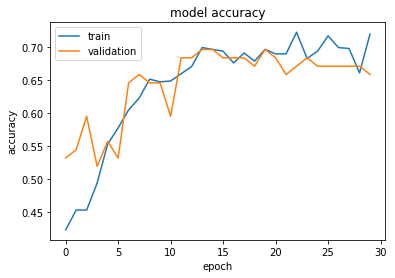

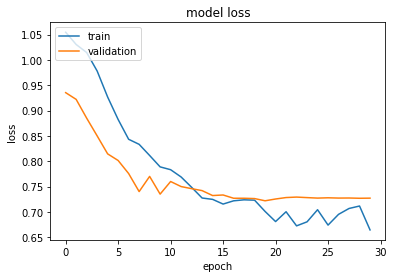

Time passed for training 195.7546021938324
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 8 45 50 53 67] val_indices[-5:] [774 775 780 800 802]

class_weights [0.71 1.82 0.96]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 731 	 VAL size: 79
Train label distribution:  label
-1    134
 0    342
 1    255
Name: label, dtype: int64
Val label distribution:  label
-1    13
 0    36
 1    30
Name: label, dtype: int64
Train on 731 samples, validate on 79 samples
Epoch 1/100
731/731 [==============================] - 8s 10ms/step - loss: 1.0642 - acc: 0.4487 - f1: 0.1405 - recall: 0.0862 - precision: 0.4421 - val_loss: 1.0241 - val_acc: 0.4430 - val_f1: 0.1837 - val_recall: 0.1139 - val_precision: 0.5842
Epoch 2/100
731/731 [==============================] - 5s 7ms/step - loss: 1.0235 - acc: 0.4925 - f1: 0.1289 - recall: 0.0766 - precision: 0.4842 - val_loss: 0.9983 - val_acc: 0.5063 - val_f1: 0.2070 - val_recall: 0.1266 - val_precision: 0.6970
Epoch 

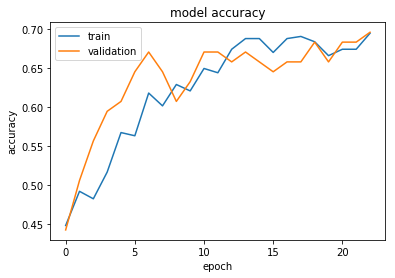

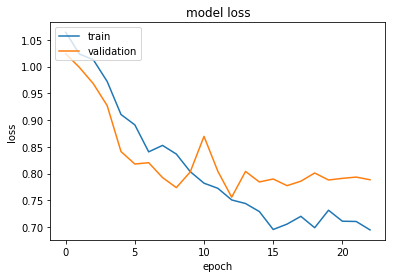

Time passed for training 161.8051323890686
Cross-validation val accuracy results:  [0.6219512195121951, 0.5853658536585366, 0.6463414634146342, 0.7195121951219512, 0.6951219512195121, 0.6296296296296297, 0.7901234567901234, 0.6875, 0.6962025346635263, 0.6962025354180155]
Cross-validation val accuracy results: 0.68% (+/- 0.06%)

 Cross-validation val f1 results:  [0.6089964087416486, 0.5480198976470203, 0.6223897643205596, 0.6139254148413495, 0.6469862054033977, 0.6014070900869958, 0.7366595798068576, 0.6721773743629456, 0.6532401110552535, 0.6669472652145579]
Cross-validation val f1 results: 0.64% (+/- 0.05%)
max_seq_len 38
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_44 (Masking)         (None, None, 200)         0         
_________________________________________________________________
lstm_87 (LSTM)               (None, None, 38)          36328     
______________________________________

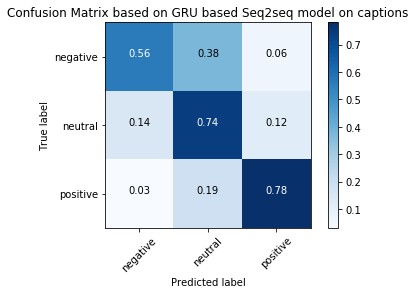

dirty damaged photograph woman messy hair holding head hands. TL -1 PL 1
bald man head wooden table. grasps empty liquor bottle right hand. shot glass seen behind left arm. TL -1 PL 0
swimmer pool lane markers turning head take breath swimming. TL 1 PL 0
pigeon ground seeds scattered around it. TL 0 PL -1
ray resting seabed small striped fish swimming it. TL 0 PL 1
sunset small cemetery. TL 0 PL 1
operating room patient lying covered table surgeon operating nurses assisting. TL 0 PL -1
weasel sitting upright like human being. TL 0 PL -1
black white photo woman sitting ground one hand face top head. TL -1 PL 0
pasta salad olives tomatoes TL 0 PL -1
three men two women dressed medieval costumes sit benches wooden table. table horn, furred hat, apple it. shield nearby. TL 1 PL 0
white dog running across grass ears flying. TL 1 PL 0
three girls ring holding hands. outdoors. brown skin straight black hair. TL 1 PL 0
man's hand, holding black white bird. TL 0 PL -1
dog leash mouth open, look

In [21]:
def build_model(max_seq_len, num_of_classes, config): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))

#     model.add(Bidirectional(GRU(max_seq_len, return_sequences=True, dropout=config['dropout'],
#                                 recurrent_dropout=config['recurrent_dropout']), merge_mode='concat'))
#     model.add(Bidirectional(GRU(max_seq_len, dropout=config['dropout'] - 0.1, 
#                                 recurrent_dropout=config['recurrent_dropout'] - 0.1 ), merge_mode='concat'))    
    model.add(LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(Dense(num_of_classes, activation='softmax'))
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
        

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    #print(model.summary())
    return model




def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    X_test, y_test_index, _, _, _  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
        
    predictions = model.predict(X_test, verbose=1)    
    print("predictions:\n",predictions)
    print("\n")
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    print("y_true:\n", y_true)
    print("\n")
    y_pred = predictionClasses
    print("y_pred:\n", y_pred)
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)


def train_StratifiedKFold(inputDataset, testDataset, wordToVec, config):
    """StratifiedKFold cross-validation"""
    # Shuffle dataset
    df = shuffle(inputDataset)
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    cv_accuracies = []
    cv_f1s = []
    
    best_model = None
    best_model_best_acc = -1
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("train_indices[:5]", train_indices[:5],"train_indices[-5:]",train_indices[-5:])
        print("val_indices[:5]", val_indices[:5],"val_indices[-5:]",val_indices[-5:])
        print()
        
        
        start = time.time()        
        class_to_index = {}
        index_to_class = {}
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train_caption, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes, class_to_index, index_to_class = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
        y_ints = [y.argmax() for y in y_train]
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
        print("class_weights", class_weights)
        print("class_to_index", class_to_index)
        
        dfVal= pd.concat([X_val_caption, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        X_val, y_val_index, _, _, _ = caput.load_dataset_StratifiedKFold(
                            dfVal,
                            wordToVec,
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
        
        
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        print("Val label distribution: ",dfVal.groupby('label').label.count())

        
        model = build_model(max_seq_len,num_of_classes, config)
        
        plot_model(model, to_file = model_results_root_dir + '/model.png', show_shapes=True, show_layer_names=True)#
        
        
        # Log to tensorboard
        tensorBoardCallback = TensorBoard(log_dir=model_results_root_dir + '/logs', write_graph=True)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=2, 
                                  min_lr=1e-7,
                                  cooldown=1,
                                  verbose=1)
        
        history = {}
        filename = ""
        # checkpoint
        filepath= model_results_root_dir + "/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        
        callbacks_list = [checkpoint,  reduce_lr, early_stopping, tensorBoardCallback]  # 
        
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=config['batch_size'],
                      epochs=config['nb_epochs'], 
                      verbose=config['verbose'], 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list,
                      class_weight = class_weights)        # 
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if config['useF1Score']:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "caption" 
        filename = model_results_root_dir + caput.generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])
        
        end = time.time()
        print("Time passed for training", (end-start))
        
        if best_val_acc > best_model_best_acc:
            best_model_best_acc = best_val_acc
            best_model = model
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    best_model.save(model_results_root_dir + "/bestmodel-" + str(best_model_best_acc) + ".h5")
    return best_model


def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    conf['seed'] = seed
    return conf    
    
best_model = None
def main():
    global wordToVec, best_model
    config = get_config()
    print("config:\n", config)
    if wordToVec is None:
        wordToVec = load_embedding(fasttext_embedding_path)
    print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
    best_model = train_StratifiedKFold(inputDataset, testDataset, wordToVec, config)
    # Evaluate Test data set
    evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()

## Determien Vocabulary size - unique word counts

In [8]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
vocabulary = set()
for index, row in df.iterrows():
    caption = row['caption']
    words = caption.lower().split()
    for word in words:
        vocabulary.add(word)
    
print("Voc size: ",len(vocabulary))    

Voc size:  2827
